# 📖Blibiotecas importadas
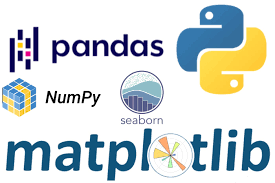



In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


# *data base*





In [75]:
#extract base
base_Telecom = pd.read_csv('https://raw.githubusercontent.com/DanJisus/Proyecto-Telecom-X-alura-Latam/main/df_TelecomX_Final_1.csv')


#clear bases
print((base_Telecom := base_Telecom.assign(gender=base_Telecom['gender'].map({'Male': 1, 'Female': 0})))['gender'].unique())


#clear data irrelevant

xIn, yOut = (base_Telecom := base_Telecom.drop(columns='customerID')).drop(columns='Churn'), base_Telecom['Churn']

base_Telecom.head()


[0 1]


,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0,0,0,1,1,9,1,0,DSL,0,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.16
1,0,1,0,0,0,9,1,1,DSL,0,...,0,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,1.97
2,1,1,0,0,0,4,1,0,Fiber optic,0,...,1,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.43
3,1,1,1,1,0,13,1,0,Fiber optic,0,...,1,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.22
4,1,0,1,1,0,3,1,0,Fiber optic,0,...,0,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.76


In [76]:
# Umbral y eliminación de columnas desbalanceadas

umbral = 0.70
columnas_a_eliminar = []

for columna in base_Telecom.columns:
    if base_Telecom[columna].nunique() <= 2 or base_Telecom[columna].dtype == 'object':
        frecuencia_max = base_Telecom[columna].value_counts(normalize=True).max()
        if frecuencia_max > umbral:
            columnas_a_eliminar.append(columna)
            print(f"Columna '{columna}' tiene {frecuencia_max*100:.2f}% en una categoría.")
if columnas_a_eliminar:
    print(f"\nColumnas a eliminar por desbalance (>{umbral*100}% en una categoría):")
    print(columnas_a_eliminar)
else:
    print(f"No se encontraron columnas con desbalance >{umbral*100}%.")





Columna 'Churn' tiene 74.28% en una categoría.
Columna 'SeniorCitizen' tiene 83.73% en una categoría.
Columna 'PhoneService' tiene 90.27% en una categoría.
Columna 'OnlineSecurity' tiene 71.40% en una categoría.
Columna 'TechSupport' tiene 71.05% en una categoría.

Columnas a eliminar por desbalance (>70.0% en una categoría):
['Churn', 'SeniorCitizen', 'PhoneService', 'OnlineSecurity', 'TechSupport']


In [77]:
#Datos irrelevantes para el modelo <90%
base_Telecom = base_Telecom.drop(columns='PhoneService')
base_Telecom.columns



Index(['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly',
       'Charges.Total', 'Cuentas_Diarias'],
      dtype='object')

In [78]:
categoricas = base_Telecom.select_dtypes(include=['object']).columns.tolist()
print("Variables categóricas:", categoricas)


Variables categóricas: ['InternetService', 'Contract', 'PaymentMethod']


In [79]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

columnas=xIn.columns
one_hot_encoder = make_column_transformer(
    (OneHotEncoder(drop='if_binary'),categoricas),
    remainder='passthrough',
    sparse_threshold=0
)
x=one_hot_encoder.fit_transform(xIn)
one_hot_encoder.get_feature_names_out(columnas)
xIn=pd.DataFrame(x, columns=one_hot_encoder.get_feature_names_out(columnas))

# *balanceo*

In [90]:
over_sampling=SMOTE()
x_over,y_over=over_sampling.fit_resample(xIn,yOut)

y_over.value_counts(normalize=False)

,count
Churn,
0,5398
1,5398


# *Correlacion*

In [91]:
datosOneHotEncoder=pd.concat([x_over.reset_index(drop=True), y_over.reset_index(drop=True)], axis=1)
datosOneHotEncoder


datosOHE=datosOneHotEncoder.corr()
datosOHE['Churn']

variables_correlacionadas = [
    "onehotencoder__Contract_Month-to-month",
    "remainder__tenure",
    "onehotencoder__Contract_Two year",
    "onehotencoder__InternetService_Fiber optic",
    "onehotencoder__PaymentMethod_Electronic check",
    "onehotencoder__InternetService_No",
    "onehotencoder__Contract_One year",
    "remainder__Charges.Monthly",
    "remainder__Cuentas_Diarias",
    "remainder__Dependents",
    "remainder__TechSupport",
    "remainder__OnlineSecurity",
    "remainder__PaperlessBilling",
    "remainder__Partner",
    "remainder__SeniorCitizen"
]

In [96]:

def ancho_bin(df,columna):
  q75,q25 = np.percentile(df[columna],[75,25])
  iqr = q75-q25
  ancho = 2 * iqr * np.power(len(df[columna]), -1/3)
  return int(ancho)

/tmp/ipython-input-1636842452.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=base_Telecom, x='Churn', y='tenure', palette='Set2')


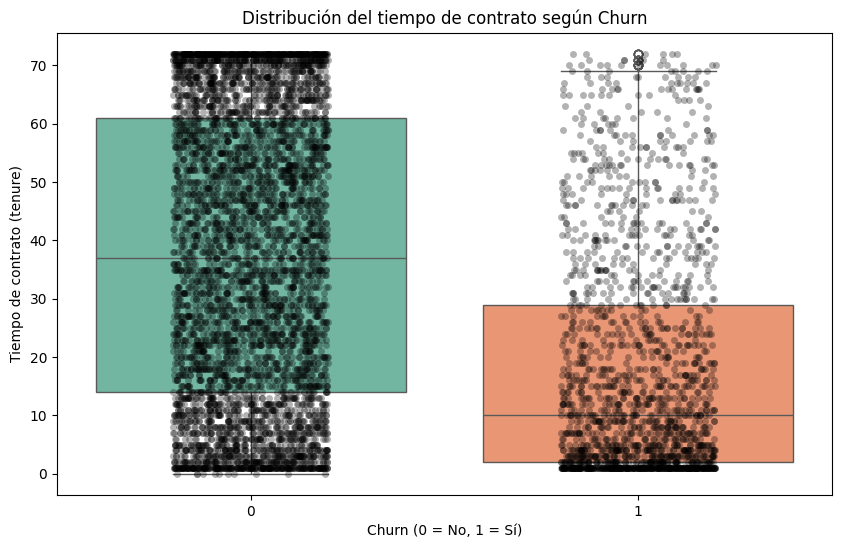

In [103]:
data_churn = base_Telecom[base_Telecom['Churn'] == 1]

plt.figure(figsize=(10, 6))
sns.boxplot(data=base_Telecom, x='Churn', y='tenure', palette='Set2')
sns.stripplot(data=base_Telecom, x='Churn', y='tenure', color='black', alpha=0.3, jitter=0.2)
plt.title('Distribución del tiempo de contrato según Churn')
plt.xlabel('Churn (0 = No, 1 = Sí)')
plt.ylabel('Tiempo de contrato (tenure)')
plt.show()

/tmp/ipython-input-1633249705.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=base_Telecom, x='Churn', y='tenure', palette='coolwarm')


<Axes: xlabel='Churn', ylabel='tenure'>

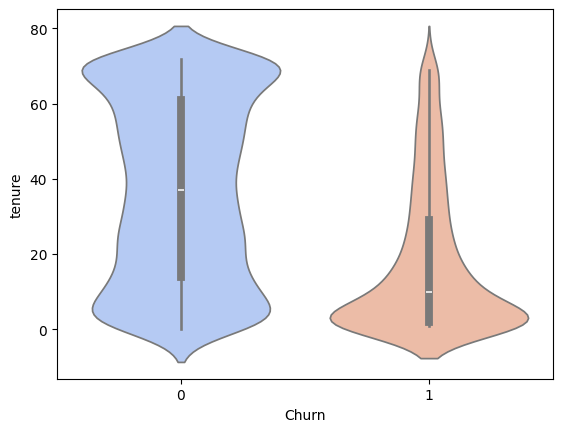

In [100]:
sns.violinplot(data=base_Telecom, x='Churn', y='tenure', palette='coolwarm')

In [115]:
base_Telecom.columns = base_Telecom.columns.str.replace('.', '_', regex=False)



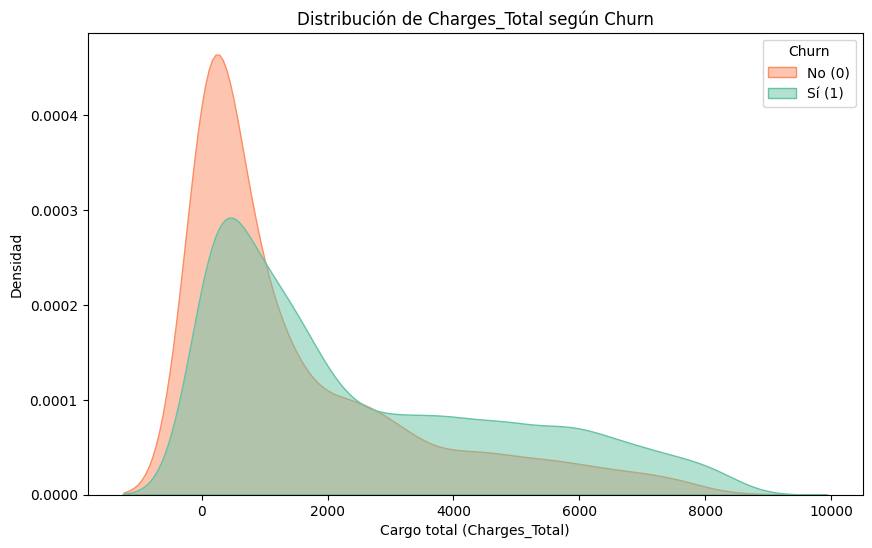

In [118]:
# Asegurar que sea numérico
base_Telecom['Charges_Total'] = pd.to_numeric(base_Telecom['Charges_Total'], errors='coerce')

# Crear el gráfico de densidad
plt.figure(figsize=(10, 6))
sns.kdeplot(data=base_Telecom, x='Charges_Total', hue='Churn', fill=True, common_norm=False, palette='Set2', alpha=0.5)
plt.title('Distribución de Charges_Total según Churn')
plt.xlabel('Cargo total (Charges_Total)')
plt.ylabel('Densidad')
plt.legend(title='Churn', labels=['No (0)', 'Sí (1)'])
plt.show()

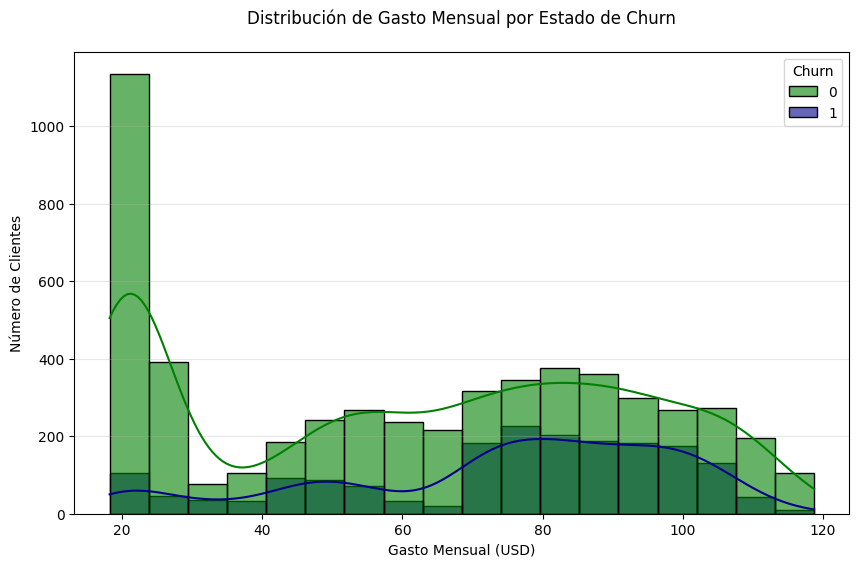

In [136]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=base_Telecom,
    x='Charges_Monthly',  # Usa aquí el nombre correcto
    hue='Churn',
    kde=True,
    bins='auto',
    palette={0: 'green', 1: 'darkblue'},
    alpha=0.6,
    multiple='layer'
)
plt.title("Distribución de Gasto Mensual por Estado de Churn", pad=20)
plt.xlabel("Gasto Mensual (USD)")
plt.ylabel("Número de Clientes")
plt.grid(axis='y', alpha=0.3)
plt.show()


Random Forest - Accuracy: 0.868
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1080
           1       0.85      0.89      0.87      1080

    accuracy                           0.87      2160
   macro avg       0.87      0.87      0.87      2160
weighted avg       0.87      0.87      0.87      2160



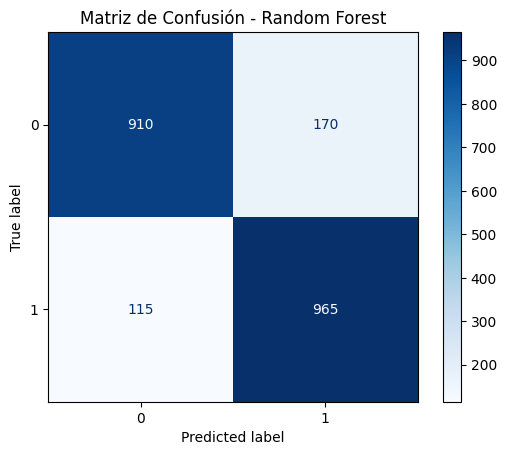

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Dummy Classifier - Accuracy: 0.500
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1080
           1       0.00      0.00      0.00      1080

    accuracy                           0.50      2160
   macro avg       0.25      0.50      0.33      2160
weighted avg       0.25      0.50      0.33      2160



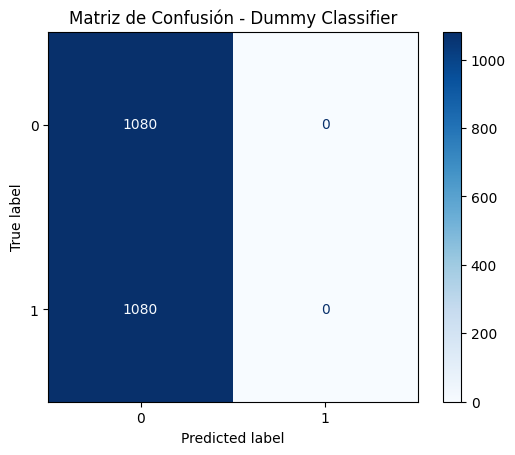


Decision Tree - Accuracy: 0.810
              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1080
           1       0.79      0.85      0.82      1080

    accuracy                           0.81      2160
   macro avg       0.81      0.81      0.81      2160
weighted avg       0.81      0.81      0.81      2160



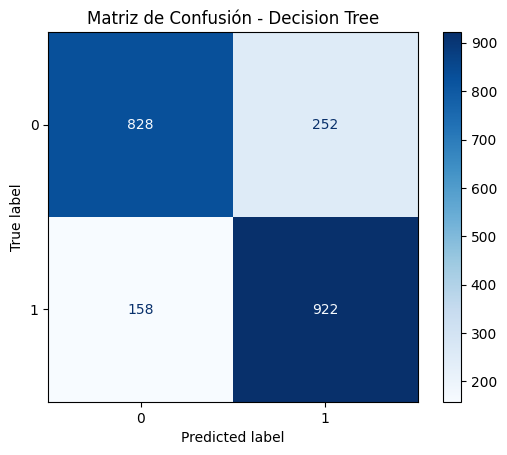

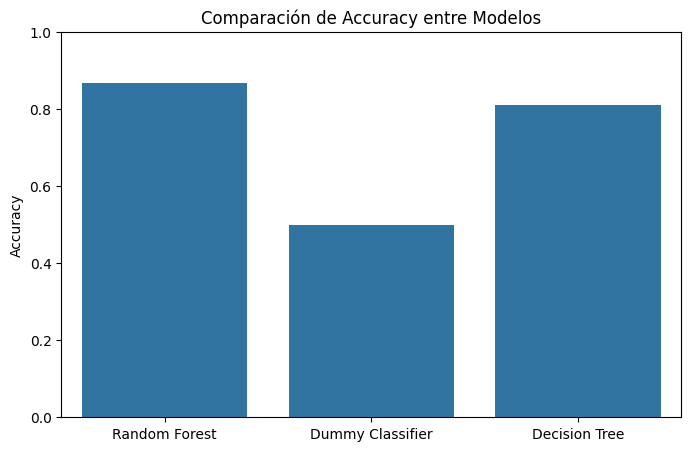

In [138]:
# Codificar etiquetas
y = LabelEncoder().fit_transform(y_over)

# Dividir datos
x_train, x_test, y_train, y_test = train_test_split(
    x_over, y, test_size=0.2, random_state=42, stratify=y_over
)

# Entrenar modelos
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42, max_depth=10),
    'Dummy Classifier': DummyClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5)
}

resultados = {}

for nombre, modelo in modelos.items():
    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)

    # Guardar métricas y predicciones
    resultados[nombre] = {
        'model': modelo,
        'accuracy': modelo.score(x_test, y_test),
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(f"\n{nombre} - Accuracy: {resultados[nombre]['accuracy']:.3f}")
    print(classification_report(y_test, y_pred))

    # Mostrar matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=resultados[nombre]['confusion_matrix'])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

# Comparar accuracy de todos los modelos en un gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(x=list(resultados.keys()), y=[r['accuracy'] for r in resultados.values()])
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre Modelos')
plt.ylim(0,1)
plt.show()


📊 Comparación de Modelos de Clasificación

| Modelo             | Accuracy | Precision (No Churn) | Precision (Churn) | Recall (No Churn) | Recall (Churn) | F1-score (No Churn) | F1-score (Churn) |
|--------------------|----------|----------------------|-------------------|-------------------|----------------|----------------------|------------------|
| Random Forest      | 0.868    | 0.89                 | 0.85              | 0.84              | 0.89           | 0.86                 | 0.87             |
| Decision Tree      | 0.810    | 0.84                 | 0.79              | 0.77              | 0.85           | 0.80                 | 0.82             |
| Dummy Classifier   | 0.500    | 0.50                 | 0.00              | 1.00              | 0.00           | 0.67                 | 0.00             |

🌲 1. Random Forest

Random Forest es el modelo con mejor desempeño general. muestra la mayor presision.
Su equilibrio entre precisión y recall lo convierte en un modelo confiable y robusto para detectar churn sin perder muchos clientes valiosos. 🚀

🌳 2. Decision Tree

Este metodo esta se segundo por que puede tener menos presision para la clase No churn lo que en desempeño le quita puntos

🤖 3. Dummy Classifier

Para este modelo , segun los datos de la tabla , demuestra un desempeño mas bajo de lo habitual , generando data impresisa y poco fiable

✅ Conclusión

🏆 Random Forest es el mejor que se debe utilizar por su alta presision

🌿 Decision Tree es una buena opcion, pero sacrificamos la presision y en el anailisis del Out de servicio es mas importante validar con presision el porque y el como

🚫 Dummy Classifier no es recomendablle usar en este tipos de datos.

🎯 Recomendación:
utilizar el Random forest ayudara con mayor presision identificiar los posibles "out del servicio.

# 📊 Principales factores

El gasto mensual es bastante elevado en la categoria "No" por los "out" de servicio contienen  un factor impoortane del gasto.



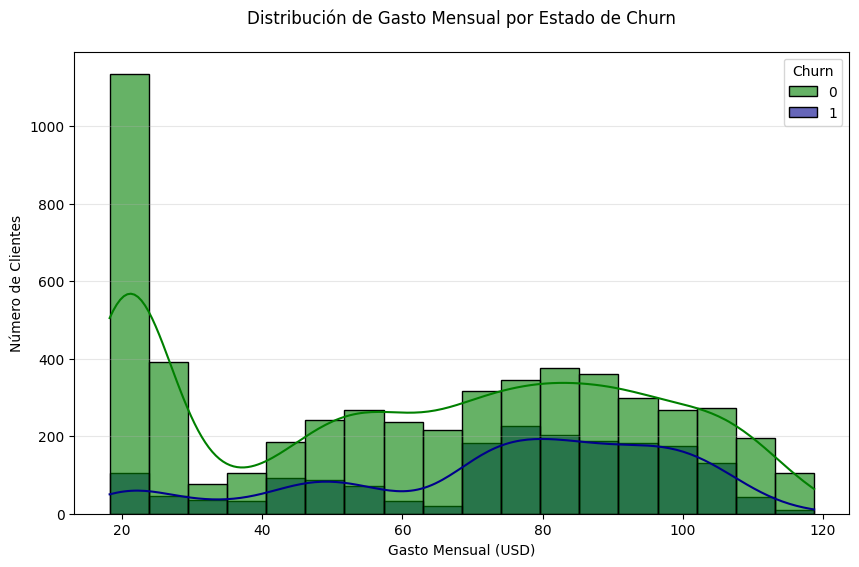

no existen retencion de clientes adecuada, tal como se grafica , la distribucion de clientes que manntiene el contrato en el primer mes es elevada.

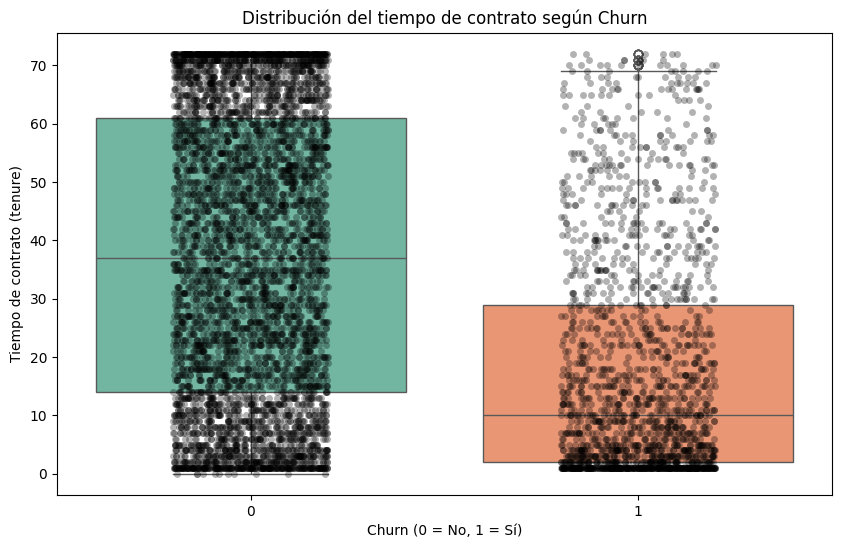

# 📊 Recomendaciones

*   No existe una estragegia de mercado definida, la cantidad de clientes que desisten del servicio , demuestra que no existen estategias definidias ni para la retencion ni para la post venta

*  Definir seguimiento de clientes dentro del primer mes para conocer la satisfacion del clientes.

*   Evaluar la calidad del servicio brindado , conforme a estadisticas descrptivas y evaluacion periodica

*   Generar informes mensuales de satisfacion

*  generar ofertas para nuevos clientes y promociones para mantener a los ya activos
*   buscar asesoramiento de mercado para la mejora de productos y comparar contra competidores para identificar valores del "out" del servicio




